Using Principal Component Analysis (PCA)

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.4 MB/s eta 0:00:00


Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# Function to load data from CSV or JSON
def load_data(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or JSON.")

# Function to perform data preprocessing for classification and regression data
def preprocess_data(df, target_variable):
    df_features = df.drop(columns=[target_variable])
    df_features = df_features.fillna(df_features.median())  # Handle missing values
    numerical_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_features.select_dtypes(include=[object, 'category']).columns.tolist()

    encoder = None
    if len(numerical_cols) > 0 and len(categorical_cols) == 0:
        encoder = None
    elif len(numerical_cols) == 0 and len(categorical_cols) > 0:
        if all(df_features[col].nunique() < 10 for col in categorical_cols):
            encoder = OneHotEncoder(drop='first', sparse=False)
        elif all(10 <= df_features[col].nunique() <= 100 for col in categorical_cols):
            encoder = LeaveOneOutEncoder()
        else:
            encoder = CatBoostEncoder()
    else:
        if all(df_features[col].nunique() < 10 for col in categorical_cols):
            encoder = OneHotEncoder(drop='first', sparse=False)
        elif all(10 <= df_features[col].nunique() <= 100 for col in categorical_cols):
            encoder = LeaveOneOutEncoder()
        else:
            encoder = CatBoostEncoder()

    if encoder is not None:
        if isinstance(encoder, OneHotEncoder):
            df_features_encoded = encoder.fit_transform(df_features[categorical_cols])
            df_features = df_features.drop(columns=categorical_cols)
            df_features = pd.concat([df_features, pd.DataFrame(df_features_encoded, columns=encoder.get_feature_names_out())], axis=1)
        else:
            df_features[categorical_cols] = encoder.fit_transform(df_features[categorical_cols], df[target_variable])

    return df_features

# Function to perform PCA and return explained variance ratio
def perform_pca(df):
    pca = PCA()
    pca.fit(df)
    explained_variance_ratio = pca.explained_variance_ratio_
    return explained_variance_ratio, pca

# Function to plot Scree plot
def plot_scree(explained_variance_ratio):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

Model Development and Evaluation

In [ ]:
# Function to evaluate models for classification
def evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'Support Vector Classifier': SVC(),
        'XGBoost Classifier': XGBClassifier(n_estimators=100)
    }

    results = {}

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = {
            'Training time': training_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

    return results

# Function to evaluate models for regression
def evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
        'Support Vector Regressor': SVR(),
        'XGBoost Regressor': XGBRegressor(n_estimators=100)
    }

    results = {}

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = {
            'Training time': training_time,
            'Mean Squared Error': mse,
            'R^2 Score': r2,
            'Mean Absolute Error': mae
        }

    return results

# Load the dataset
file_path = 'your_dataset.csv'  # Replace with your file path
df = load_data(file_path)
target_variable = 'your_target_variable'
dataset_type = 'classification'  # Change to 'regression' if the task is of regression

# Preprocess data
df_features = preprocess_data(df, target_variable)
X = df_features.values
y = df[target_variable].values

# PCA analysis
explained_variance_ratio, pca = perform_pca(df_features)
plot_scree(explained_variance_ratio)
total_variance = explained_variance_ratio.cumsum()[-1]
print(f"\nTotal Variance Explained by PCA: {total_variance:.4f}")

# Split data and evaluate models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

if dataset_type == 'regression':
    evaluation_results = evaluate_regression_models(X_train, X_test, y_train, y_test)
    print("\nModel Evaluation Results for Regression:")
elif dataset_type == 'classification':
    evaluation_results = evaluate_classification_models(X_train, X_test, y_train, y_test)
    print("\nModel Evaluation Results for Classification:")

# Print evaluation results
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")


Total Explained Variance: 1.0000000000000002
Number of components to retain for capturing 99.0% variance: 31

Scree Plot of Principal Components capturing Total Variance: 



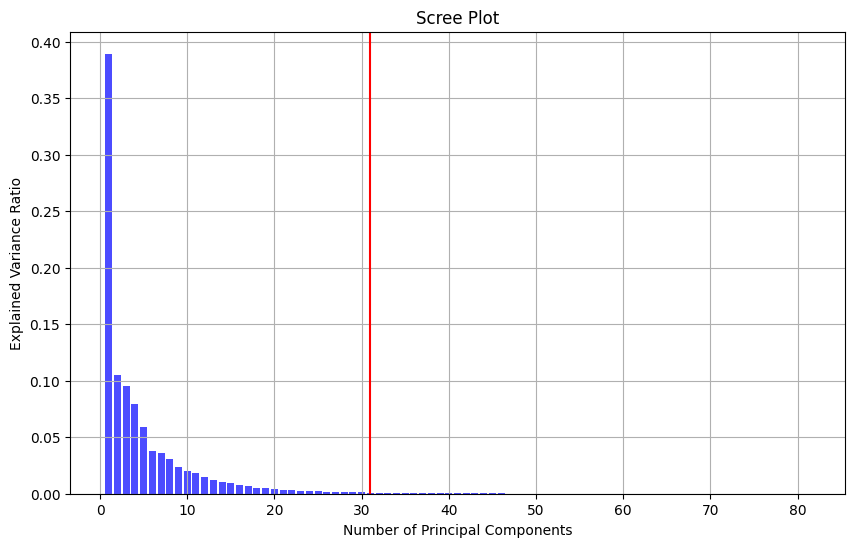

In [ ]:
import pandas as pd
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('train.csv')

# Specifying the target variable
target_variable = 'critical_temp'

# Function to perform data preprocessing
def preprocess_data(df, target_variable):
    # Drop target variable for preprocessing
    df_features = df.drop(columns=[target_variable])

    # Handling missing values for numeric columns (replace with median)
    df_features = df_features.fillna(df_features.median())

    # Determine feature types
    numerical_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_features.select_dtypes(include=[object, 'category']).columns.tolist()

    # Initialize encoder
    encoder = None

    if len(numerical_cols) > 0 and len(categorical_cols) == 0:
        # All numerical features
        encoder = None
    elif len(numerical_cols) == 0 and len(categorical_cols) > 0:
        # All categorical features
        if all(df_features[col].nunique() < 10 for col in categorical_cols):
            encoder = OneHotEncoder(drop='first', sparse=False)
        elif all(10 <= df_features[col].nunique() <= 100 for col in categorical_cols):
            encoder = LeaveOneOutEncoder()
        else:
            encoder = CatBoostEncoder()
    else:
        # Mixed features
        if all(df_features[col].nunique() < 10 for col in categorical_cols):
            encoder = OneHotEncoder(drop='first', sparse=False)
        elif all(10 <= df_features[col].nunique() <= 100 for col in categorical_cols):
            encoder = LeaveOneOutEncoder()
        else:
            encoder = CatBoostEncoder()

    if encoder is not None:
        if isinstance(encoder, OneHotEncoder):
            df_features_encoded = encoder.fit_transform(df_features[categorical_cols])
            df_features = df_features.drop(columns=categorical_cols)
            df_features = pd.concat([df_features, pd.DataFrame(df_features_encoded, columns=encoder.get_feature_names_out())], axis=1)
        else:
            df_features[categorical_cols] = encoder.fit_transform(df_features[categorical_cols], df[target_variable])

    return df_features

# Perform data preprocessing
df_features = preprocess_data(df, target_variable)

# StandardScaler for all columns except target variable
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Create a DataFrame from scaled data
df_processed = pd.DataFrame(df_features_scaled, columns=df_features.columns)

# Function to perform PCA and return explained variance ratio
def perform_pca(df):
    pca = PCA()
    pca.fit(df)
    explained_variance_ratio = pca.explained_variance_ratio_
    return explained_variance_ratio, pca

# Perform PCA on the processed data
explained_variance, pca = perform_pca(df_processed)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Find the number of components required to reach 99% explained variance
threshold = 0.99
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

total_explained_variance = sum(explained_variance)
print(f"\nTotal Explained Variance: {total_explained_variance}")
# Determining the optimal number of principal components
print(f"Number of components to retain for capturing {threshold * 100}% variance: {num_components}")

# Transform the data using the selected number of components
pca = PCA(n_components=num_components)
transformed_data = pca.fit_transform(df_processed)

print("\nScree Plot of Principal Components capturing Total Variance: \n")

# Generate the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.axvline(x=num_components, color='r', linestyle='-')
plt.grid(True)
plt.show()

# Prepare data for model training
X = transformed_data

# Check if the target variable is continuous or categorical
is_numeric = pd.api.types.is_numeric_dtype(df[target_variable])


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew

# Define skewness thresholds
HIGH_SKEW_THRESHOLD = 1.0
MODERATE_SKEW_THRESHOLD = 0.5

# Function to calculate skewness and apply transformations based on skewness
def calculate_skewness_and_transform(df, target_variable):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    skewness_dict_before = {}
    skewness_dict_after = {}

    for col in numeric_cols:
        if col != target_variable:
            original_skewness = skew(df[col].dropna())
            skewness_dict_before[col] = original_skewness

            if original_skewness > HIGH_SKEW_THRESHOLD:
                # Apply log10 transformation if skewness is high
                if (df[col] > 0).all():  # Ensure all values are positive
                    df[col] = np.log10(df[col])
                else:
                    # Apply cube root transformation if log transformation is not applied
                    df[col] = np.cbrt(df[col] + 1e-10)  # Add a small constant to avoid zero values

            elif original_skewness > MODERATE_SKEW_THRESHOLD:
                # Apply cube root transformation if skewness is moderate
                df[col] = np.cbrt(df[col] + 1e-10)  # Add a small constant to avoid zero values

            else:
                # Apply square root transformation if skewness is low
                df[col] = np.sqrt(df[col].clip(lower=0))

            transformed_skewness = skew(df[col].dropna())
            skewness_dict_after[col] = transformed_skewness

    return skewness_dict_before, skewness_dict_after

# Assume df is your existing dataframe and target_variable is specified
# Calculate skewness and transform
skewness_before, skewness_after = calculate_skewness_and_transform(df, target_variable)

# Print skewness values before transformation
print("\nSkewness of the dataset before transformation: \n")
for feature, skew_value in skewness_before.items():
    print(f"{feature}: {skew_value:.4f}")

# Print skewness values after transformation
print("\nSkewness of the dataset after transformation: \n")
for feature, skew_value in skewness_after.items():
    print(f"{feature}: {skew_value:.4f}")

# Calculate and print skewness for the target variable separately before transformation
target_skewness_before = skew(df[target_variable].dropna())
print(f"\nSkewness of the target variable '{target_variable}' before transformation: {target_skewness_before:.4f}")

# Apply square root transformation to the target variable
df[target_variable] = np.sqrt(df[target_variable].clip(lower=0))

# Calculate and print skewness for the target variable after transformation
target_skewness_after = skew(df[target_variable].dropna())
print(f"\nSkewness of the target variable '{target_variable}' after transformation: {target_skewness_after:.4f}")


Skewness of the dataset before transformation: 

number_of_elements: 0.0092
mean_atomic_mass: 0.7746
wtd_mean_atomic_mass: 1.5038
gmean_atomic_mass: 1.4747
wtd_gmean_atomic_mass: 1.6982
entropy_atomic_mass: -0.7852
wtd_entropy_atomic_mass: -0.6268
range_atomic_mass: -0.3771
wtd_range_atomic_mass: 2.4636
std_atomic_mass: -0.3483
wtd_std_atomic_mass: -0.3083
mean_fie: 1.0097
wtd_mean_fie: -0.2897
gmean_fie: 1.1918
wtd_gmean_fie: -0.3148
entropy_fie: -0.7925
wtd_entropy_fie: -0.0303
range_fie: -0.4563
wtd_range_fie: -0.2780
std_fie: -0.4525
wtd_std_fie: -0.4099
mean_atomic_radius: -0.5655
wtd_mean_atomic_radius: 0.5668
gmean_atomic_radius: 0.0921
wtd_gmean_atomic_radius: 0.5526
entropy_atomic_radius: -0.7498
wtd_entropy_atomic_radius: -0.7891
range_atomic_radius: -0.6875
wtd_range_atomic_radius: 1.6430
std_atomic_radius: -0.7492
wtd_std_atomic_radius: -0.6459
mean_Density: 2.1032
wtd_mean_Density: 2.1376
gmean_Density: 1.6590
wtd_gmean_Density: 1.6508
entropy_Density: -0.8074
wtd_entropy

In [ ]:
# Function to evaluate different models for classification
def evaluate_classification_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'Support Vector Classifier': SVC(),
        'XGBoost Classifier': XGBClassifier(n_estimators=100)
    }

    results = {}

    # Evaluation metrics for classification task: Precision, Recall, F1-Score
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = {
            'Training time': training_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall, 'F1 Score': f1
        }

    return results

# Function to evaluate different models for regression
def evaluate_regression_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
        'Support Vector Regressor': SVR(),
        'XGBoost Regressor': XGBRegressor(n_estimators=100)
    }

    results = {}

    # Evaluation metrics for regression task: MSE, R^2, MAE
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = {
            'Training time': training_time,
            'Mean Squared Error': mse,
            'R^2 Score': r2,
            'Mean Absolute Error': mae
        }

    return results

# If the target variable is numeric, perform regression
if is_numeric:
    y = df[target_variable].astype(float)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Evaluate regression models
    evaluation_results = evaluate_regression_models(X_train, X_test, y_train, y_test)
    print("\nModel Evaluation Results for Regression:")
else:
    # Convert the target variable to numeric values starting from 0 for classification
    y = df[target_variable].str.strip("'").astype(int) - 1
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Evaluate classification models
    evaluation_results = evaluate_classification_models(X_train, X_test, y_train, y_test)
    print("\nModel Evaluation Results for Classification:")

# Print the evaluation results
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")


Model Evaluation Results for Regression:

Linear Regression:
  Training time: 0.1515
  Mean Squared Error: 2.3329
  R^2 Score: 0.7442
  Mean Absolute Error: 1.2086

Decision Tree:
  Training time: 1.1790
  Mean Squared Error: 1.0445
  R^2 Score: 0.8855
  Mean Absolute Error: 0.5930

Random Forest:
  Training time: 74.6792
  Mean Squared Error: 0.6424
  R^2 Score: 0.9296
  Mean Absolute Error: 0.5042

Gradient Boosting:
  Training time: 26.0578
  Mean Squared Error: 1.4585
  R^2 Score: 0.8401
  Mean Absolute Error: 0.9159

Support Vector Regressor:
  Training time: 27.4647
  Mean Squared Error: 1.3483
  R^2 Score: 0.8522
  Mean Absolute Error: 0.7700

XGBoost Regressor:
  Training time: 7.9299
  Mean Squared Error: 0.7336
  R^2 Score: 0.9196
  Mean Absolute Error: 0.5705


In [ ]:
# Function to evaluate different models
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'Support Vector Classifier': SVC(),
        'XGBoost Classifier': XGBClassifier(n_estimators=100)
    }

    results = {}

    # Evaluation metrics for classification task: Precision, Recall, F1-Score
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = {
            'Training time': training_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall, 'F1 Score': f1
        }

    return results

# Evaluate models and print results
evaluation_results = evaluate_models(X_train, X_test, y_train, y_test)

print("\nModel Evaluation Results after PCA:")
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model Evaluation Results after PCA:

Logistic Regression:
  Training time: 14.8069
  Accuracy: 0.9500
  Precision: 0.9505
  Recall: 0.9500
  F1 Score: 0.9500

Decision Tree:
  Training time: 1.2527
  Accuracy: 0.6840
  Precision: 0.6835
  Recall: 0.6840
  F1 Score: 0.6826

Random Forest:
  Training time: 11.4478
  Accuracy: 0.8929
  Precision: 0.8989
  Recall: 0.8929
  F1 Score: 0.8928

Gradient Boosting:
  Training time: 853.8476
  Accuracy: 0.8744
  Precision: 0.8801
  Recall: 0.8744
  F1 Score: 0.8747

Support Vector Classifier:
  Training time: 1.0980
  Accuracy: 0.9583
  Precision: 0.9606
  Recall: 0.9583
  F1 Score: 0.9586

XGBoost Classifier:
  Training time: 27.1918
  Accuracy: 0.8994
  Precision: 0.9010
  Recall: 0.8994
  F1 Score: 0.8994


In [ ]:
print(transformed_data)
print("\nShape of the Transformed Data:", transformed_data.shape)

[[ -9.4195468    0.45994744  -7.28877649 ...   0.41077129   1.16460158
   -0.58495495]
 [ -5.12472771  -1.29713081  -7.83794222 ...  -1.15019213  -0.16091379
    0.18903053]
 [-13.4003315    1.89319021 -13.89587765 ...   0.11297229   0.19668616
    1.25418407]
 ...
 [  8.74739933  -1.00326082  -4.59571153 ...   0.74572811  -0.85893578
    0.4681231 ]
 [-16.39386212   3.48123473   8.12071514 ...  -0.40756986  -0.75843866
    0.1770216 ]
 [-16.57300422  -1.36791895   8.08999793 ...   0.20412602   0.19241238
   -1.23132401]]

Shape of the Transformed Data: (7797, 114)


For Regression Tasks

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual dataset loading code)
df = pd.read_csv('Insurance_Claims.csv')

# Assuming 'CLM_PMT_AMT' is your target variable
target_variable = 'CLM_PMT_AMT'

# Function to perform data preprocessing
def preprocess_data(df):
    # Drop the first 3 columns
    df = df.drop(columns=df.columns[:3])

    # Print the type of each column in the dataset
    print("\nData Types of Each Column in the Health Insurance Claims Dataset: \n")
    print(df.dtypes)

    # Separate numeric and categorical columns
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    # Convert date columns to datetime
    date_columns = ['CLM_FROM_DT', 'CLM_THRU_DT', 'CLM_ADMSN_DT', 'NCH_BENE_DSCHRG_DT']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], format='%Y%m%d')

    # Handling missing values for numeric columns (for demonstration, replace with median)
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Handling missing values for categorical columns (for demonstration, replace with mode using forward fill)
    df[categorical_columns] = df[categorical_columns].fillna(method='ffill')

    # Extract features from date columns
    for col in date_columns:
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day

    # Drop original date columns after extracting features
    df = df.drop(columns=date_columns)

    # Update numeric and categorical columns after feature extraction
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    # Encoding categorical variables using LeaveOneOutEncoder
    encoder = LeaveOneOutEncoder()
    encoded_categorical = encoder.fit_transform(df[categorical_columns], df[target_variable])

    # Combine numeric and encoded categorical data into a single DataFrame
    df_processed = pd.concat([df[numeric_columns], encoded_categorical], axis=1)

    # Extract updated column names after preprocessing
    updated_columns = numeric_columns + list(encoded_categorical.columns)

    return df_processed, updated_columns

# Perform data preprocessing
df_processed, updated_columns = preprocess_data(df)

# StandardScaler for numeric columns
scaler = StandardScaler()
numeric_cols_to_scale = [col for col in updated_columns if col != target_variable]
df_processed[numeric_cols_to_scale] = scaler.fit_transform(df_processed[numeric_cols_to_scale])

# Function to calculate correlation for numeric columns
def calculate_numeric_correlation(df, numeric_cols, target_col):
    correlations = {}
    for col in numeric_cols:
        if col != target_col:
            corr = df[col].corr(df[target_col])
            correlations[col] = corr
    return correlations

# Calculate correlations (only numeric correlations)
numeric_correlations = calculate_numeric_correlation(df_processed, numeric_cols_to_scale, target_variable)

# Create a DataFrame for correlation results
correlation_results = pd.DataFrame({'Feature': list(numeric_correlations.keys()),
                                    'Correlation': list(numeric_correlations.values())})

# Print the type of each column in the dataset
print("\nData Types of Each Column in the Dataset after Leave-One-Out Encoding: \n")
print(df_processed.dtypes)

# Print or visualize the correlation results
print("\nPairwise Correlations between the Features and the Target Variable: \n")
print(correlation_results)

# Function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Calculate VIF for numeric columns
vif_results = calculate_vif(df_processed[numeric_cols_to_scale])

# Print VIF results
print("\nVariance Inflation Factor (VIF) Estimates: \n")
print(vif_results)

# Function to perform PCA and return explained variance ratio
def perform_pca(df):
    pca = PCA()
    pca.fit(df)
    explained_variance_ratio = pca.explained_variance_ratio_
    return explained_variance_ratio, pca

# Perform PCA on the processed data
explained_variance, pca = perform_pca(df_processed[numeric_cols_to_scale])

# Print explained variance ratio
print("\nExplained Variance Ratio after PCA: \n")
print(explained_variance)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Find the number of components required to reach 90% explained variance
threshold = 0.90
num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

total_explained_variance = sum(explained_variance)
print(f"\nTotal Explained Variance: {total_explained_variance}")
# Determining the optimal number of principal components
print(f"Number of components to retain for capturing {threshold * 100}% variance: {num_components}")

# Transform the data using the selected number of components
pca = PCA(n_components=num_components)
transformed_data = pca.fit_transform(df_processed[numeric_cols_to_scale])

print("\nScree Plot of Principal Components capturing Total Variance: \n")

# Generate the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.axvline(x=num_components, color='r', linestyle='-')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_data, df_processed[target_variable], test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100),
    'Support Vector Regressor': SVR(),
    'XGBoost Regressor': XGBRegressor(n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results[name] = {
        'Training time': end_time - start_time,
        'Mean Squared Error': mse,
        'R^2 Score': r2,
        'Mean Absolute Error': mae
    }

# Print results
print("\nModel Evaluation Results after PCA:")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Training time: {result['Training time']:.4f} seconds")
    print(f"  Mean Squared Error: {result['Mean Squared Error']:.4f}")
    print(f"  R^2 Score: {result['R^2 Score']:.4f}")
    print(f"  Mean Absolute Error: {result['Mean Absolute Error']:.4f}")


Evaluation Results after PCA:
Linear Regression:
  Training time: 0.1088 seconds
  Mean Squared Error: 51153529.8744
  R^2 Score: 0.3960
  Mean Absolute Error: 4485.8350
Decision Tree:
  Training time: 3.2528 seconds
  Mean Squared Error: 107855621.5125
  R^2 Score: -0.2735
  Mean Absolute Error: 6365.6541
Random Forest:
  Training time: 237.3401 seconds
  Mean Squared Error: 50602940.7020
  R^2 Score: 0.4025
  Mean Absolute Error: 4431.0474
Gradient Boosting:
  Training time: 79.4153 seconds
  Mean Squared Error: 48933938.0306
  R^2 Score: 0.4222
  Mean Absolute Error: 4298.5895
Support Vector Regressor:
  Training time: 212.5169 seconds
  Mean Squared Error: 85629222.8188
  R^2 Score: -0.0110
  Mean Absolute Error: 5183.7159
XGBoost:
  Training time: 1.9416 seconds
  Mean Squared Error: 51186518.7699
  R^2 Score: 0.3956
  Mean Absolute Error: 4391.3102


Without Principal Component Analysis (PCA)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('Numerical_Data.csv')

# Specifying the target variable
target_variable = 'class'

# Function to perform data preprocessing
def preprocess_data(df, target_variable):
    # Drop target variable for preprocessing
    df_features = df.drop(columns=[target_variable])

    # Handling missing values for numeric columns (replace with median)
    df_features = df_features.fillna(df_features.median())

    return df_features

# Perform data preprocessing
df_features = preprocess_data(df, target_variable)

# StandardScaler for all columns except target variable
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

# Create a DataFrame from scaled data
df_processed = pd.DataFrame(df_features_scaled, columns=df_features.columns)

# Prepare data for model training
X = df_processed.values

# Convert the target variable to numeric values starting from 0
y = df[target_variable].str.strip("'").astype(int) - 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate different models
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=2000, solver='lbfgs'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
        'Support Vector Classifier': SVC(),
        'XGBoost Classifier': XGBClassifier(n_estimators=100)
    }

    results = {}
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = {
            'Training time': training_time,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall, 'F1 Score': f1
        }

    return results

# Evaluate models and print results
evaluation_results = evaluate_models(X_train, X_test, y_train, y_test)

print("\nModel Evaluation Results:")
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")


Model Evaluation Results:

Logistic Regression:
  Training time: 69.8556
  Accuracy: 0.9571
  Precision: 0.9578
  Recall: 0.9571
  F1 Score: 0.9572

Decision Tree:
  Training time: 6.3121
  Accuracy: 0.8160
  Precision: 0.8174
  Recall: 0.8160
  F1 Score: 0.8155

Random Forest:
  Training time: 15.9664
  Accuracy: 0.9429
  Precision: 0.9444
  Recall: 0.9429
  F1 Score: 0.9429

Gradient Boosting:
  Training time: 3522.7400
  Accuracy: 0.9321
  Precision: 0.9340
  Recall: 0.9321
  F1 Score: 0.9322

Support Vector Classifier:
  Training time: 6.0345
  Accuracy: 0.9622
  Precision: 0.9639
  Recall: 0.9622
  F1 Score: 0.9624

XGBoost Classifier:
  Training time: 125.2099
  Accuracy: 0.9468
  Precision: 0.9487
  Recall: 0.9468
  F1 Score: 0.9470
